<a href="https://colab.research.google.com/github/AnwarIbrahim99/Reinforcment-learning-/blob/main/pong_setting_up_the_env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ROM is missing for pong, see https://github.com/openai/atari-py#roms for instructions


In [1]:
pip install -U gym

     |████████████████████████████████| 626 kB 4.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.23.1-py3-none-any.whl size=701374 sha256=87acf6b325f0d4f4b28b0dacd8bfafbe2fa8395e18e31e9d4b16f51002dfed0f
  Stored in directory: /root/.cache/pip/wheels/e3/33/04/6723848e46f0f1ebe794bb329b7c761c3329a0d7ffade99da7
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [2]:
pip install -U gym[atari,accept-rom-license]

     |████████████████████████████████| 1.6 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=930dbdfcb61e38f98a5c5c7482f5c3fd933184144cc8bf3e9432f38a5872a4b6
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built AutoROM.accept-rom-license


In [3]:
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.7/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/adventure.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/air_raid.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/alien.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/amidar.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/assault.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/asterix.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/asteroids.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/atlantis.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/atlantis2.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/backgammon.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/bank_heist.bin
Installed /usr/l

In [4]:
import gym
import random

# code for the two only actions in Pong
UP_ACTION = 2
DOWN_ACTION = 3

env = gym.make("Pong-v0")
#env = gym.make('SpaceInvaders-v0', render_mode='human')
# beginning of an episode
observation = env.reset()

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:506: UserWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/Pong-v5`.
  f"The environment {path} is out of date. You should consider "


In [5]:
scores=[]
observations=[]
for i in range(200):
  #env.render()

  action = random.randint(UP_ACTION,DOWN_ACTION)

  obs, reward, done, info= env.step(action)
  scores.append(reward)
  observations.append(obs)

  if done:
    env.reset()



In [6]:
import torch

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
device

device(type='cuda')

In [8]:
torch.cuda.device_count()

1

#PONG with DQN

Import Libraries

In [9]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import math

create the environment


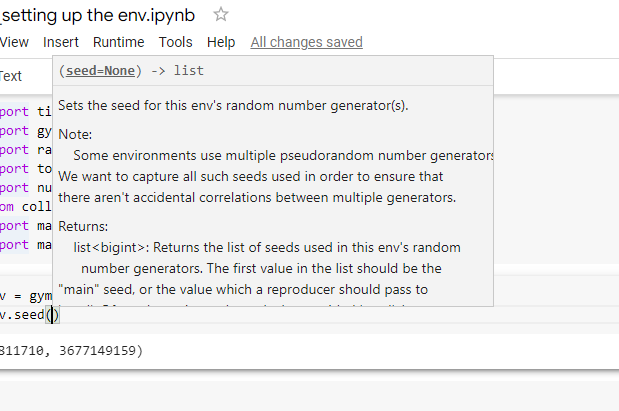

In [10]:
env = gym.make('Pong-v0')
env.seed(0)

(2968811710, 3677149159)

In [11]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


View our environment

The size of frame is:  (210, 160, 3)
No. of Actions:  6


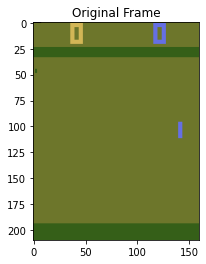

In [12]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

Palying PONG with random policy

In [13]:
def random_play():
    score = 0
    env.reset()
    while True:
        #env.render()
        #the following command randomely samples an element from this space
        #if can either be unifrom or non-uniform based on boundeness of space
        action = env.action_space.sample()
        #apply the chosen action to our env
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            env.close()
            print("Your Score at end of game is: ", score)
            break
random_play()

Your Score at end of game is:  -21.0


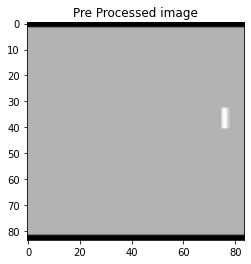

In [17]:
env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset(), (30, -4, -12, 4), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

Stacking frames

In [16]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (30, -4, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames

Preprocessing the game display the frame

In [15]:
import numpy as np
import cv2

def preprocess_frame(screen, exclude, output):
    """Preprocess Image.
        
        Params
        ======
            screen (array): RGB Image
            exclude (tuple): Section to be croped (UP, RIGHT, DOWN, LEFT)
            output (int): Size of output image
        """
    # TConver image to gray scale
    screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
    
    #Crop screen[Up: Down, Left: right] 
    screen = screen[exclude[0]:exclude[2], exclude[3]:exclude[1]]
    
    # Convert to float, and normalized
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    
    # Resize image to 84 * 84
    screen = cv2.resize(screen, (output, output), interpolation = cv2.INTER_AREA)
    return screen

def stack_frame(stacked_frames, frame, is_new):
    """Stacking Frames.
        
        Params
        ======
            stacked_frames (array): Four Channel Stacked Frame
            frame: Preprocessed Frame to be added
            is_new: Is the state First
        """
    if is_new:
        stacked_frames = np.stack(arrays=[frame, frame, frame, frame])
        stacked_frames = stacked_frames
    else:
        stacked_frames[0] = stacked_frames[1]
        stacked_frames[1] = stacked_frames[2]
        stacked_frames[2] = stacked_frames[3]
        stacked_frames[3] = frame
    
    return stacked_frames


creating the agent

The class DQNCNN

In [18]:
import torch
import torch.nn as nn
import torch.autograd as autograd 
import torch.nn.functional as F

class DQNCnn(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQNCnn, self).__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

The REPLAY Buffer

In [19]:
import numpy as np
import random
from collections import namedtuple, deque
import torch

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed, device):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
            device (string): GPU or CPU
        """

        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

The class DQN Agent

In [20]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import random
#from ..utils.replay_buffer import ReplayBuffer

class DQNAgent():
    def __init__(self, input_shape, action_size, seed, device, buffer_size, batch_size, gamma, lr, tau, update_every, replay_after, model):
        """Initialize an Agent object.
        
        Params
        ======
            input_shape (tuple): dimension of each state (C, H, W)
            action_size (int): dimension of each action
            seed (int): random seed
            device(string): Use Gpu or CPU
            buffer_size (int): replay buffer size
            batch_size (int):  minibatch size
            gamma (float): discount factor
            lr (float): learning rate 
            update_every (int): how often to update the network
            replay_after (int): After which replay to be started
            model(Model): Pytorch Model
        """
        self.input_shape = input_shape
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = device
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.update_every = update_every
        self.replay_after = replay_after
        self.DQN = model
        self.tau = tau

        
        # Q-Network
        self.policy_net = self.DQN(input_shape, action_size).to(self.device)
        self.target_net = self.DQN(input_shape, action_size).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        
        # Replay memory
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size, self.seed, self.device)
        
        self.t_step = 0

    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every

        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.replay_after:
                experiences = self.memory.sample()
                self.learn(experiences)
                
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy."""
        
        state = torch.from_numpy(state).unsqueeze(0).to(self.device)
        self.policy_net.eval()
        with torch.no_grad():
            action_values = self.policy_net(state)
        self.policy_net.train()
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Get expected Q values from policy model
        Q_expected_current = self.policy_net(states)
        Q_expected = Q_expected_current.gather(1, actions.unsqueeze(1)).squeeze(1)

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.target_net(next_states).detach().max(1)[0]
        
        # Compute Q targets for current states 
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.policy_net, self.target_net, self.tau)

    
    # θ'=θ×τ+θ'×(1−τ)
    def soft_update(self, policy_model, target_model, tau):
        for target_param, policy_param in zip(target_model.parameters(), policy_model.parameters()):
            target_param.data.copy_(tau*policy_param.data + (1.0-tau)*target_param.data)

Now the AGENT

In [21]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
BUFFER_SIZE = 100000   # replay buffer size
BATCH_SIZE = 64        # Update batch size
LR = 0.0001            # learning rate 
TAU = 1e-3             # for soft update of target parameters
UPDATE_EVERY = 1       # how often to update the network
UPDATE_TARGET = 10000  # After which thershold replay to be started 
EPS_START = 0.99       # starting value of epsilon
EPS_END = 0.01         # Ending value of epsilon
EPS_DECAY = 100         # Rate by which epsilon to be decayed

agent = DQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DQNCnn)

Watch untrained Agent

In [22]:
# watch an untrained agent
score=0
state = stack_frames(None, env.reset(), True) 
for j in range(200):
    #env.render()
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    score+=reward
    state = stack_frames(state, next_state, False)
    if done:
        break 
        
env.close()

In [23]:
score

0.0

Loading Agent

In [24]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

Train Agent with DQN

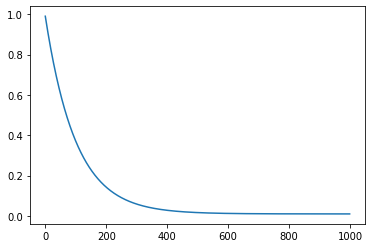

In [25]:
epsilon_by_epsiode = lambda frame_idx: EPS_END + (EPS_START - EPS_END) * math.exp(-1. * frame_idx /EPS_DECAY)

plt.plot([epsilon_by_epsiode(i) for i in range(1000)])

In [26]:
#the training funcdtion
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset(), True)
        score = 0
        eps = epsilon_by_epsiode(i_episode)
        while True:
            action = agent.act(state, eps)
            next_state, reward, done, info = env.step(action)
            score += reward
            next_state = stack_frames(state, next_state, False)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(len(scores)), scores)
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()
    
    return scores

In [ ]:
scores = train(1000)


Episode 3	Average Score: -20.67

Watch the smart agent play

In [ ]:
score = 0
state = stack_frames(None, env.reset(), True)
while True:
    env.render()
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = stack_frames(state, next_state, False)
    if done:
        print("You Final score is:", score)
        break 
env.close()